## Import libraries

In [126]:
from IPython.display import clear_output

In [143]:

%load_ext autoreload
%autoreload 2
from linien_server.autolock.robust import calculate_autolock_instructions,get_lock_position_from_autolock_instructions
from linien_server.autolock.utils import crop_spectra_to_same_view,sum_up_spectrum,get_diff_at_time_scale,get_time_scale,get_all_peaks,get_lock_region,get_target_peak
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from time import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import spectra from RP via ssh

The RP saves a set of spectra used to run the threshold analysis in order to obtain the parameters to program the fast FPGA locking algorithm. We want to get these files in order to find what's wrong with ours...

In [128]:
import subprocess

# Replace with your values
remote_user = "root"
remote_ip = "192.168.1.159"
remote_path = "/root/.local/share/linien/robust_spectra.npy"
local_path = "/home/bec3/Desktop/Simone_Damian/Serafini/Imported_files" #MODIFICATO
key_path = "~/.ssh/rp_TN" #MODIFICATO

# Use scp with SSH key
command = [
    "scp",
    "-i", key_path,
    f"{remote_user}@{remote_ip}:{remote_path}",
    local_path
]

subprocess.run(command)

# Replace with your values
remote_user = "root"
remote_ip = "192.168.1.159"
remote_path = "/root/.local/share/linien/target_idxs.npy"
local_path = "/home/bec3/Desktop/Simone_Damian/Serafini/Imported_files" #MODIFICATO
key_path = "~/.ssh/rp_TN" #MODIFICATO

# Use scp with SSH key
command = [
    "scp",
    "-i", key_path,
    f"{remote_user}@{remote_ip}:{remote_path}",
    local_path
]

subprocess.run(command)

CompletedProcess(args=['scp', '-i', '~/.ssh/rp_TN', 'root@192.168.1.159:/root/.local/share/linien/target_idxs.npy', '/home/bec3/Desktop/Simone_Damian/Serafini/Imported_files'], returncode=0)

In [56]:
#import subprocess
#
## Replace with your values
#remote_user = "root"
#remote_ip = "10.194.33.151"
#remote_port = "2223"
#remote_path = "/root/.local/share/linien/robust_spectra.npy"
#local_path = "/home/jacklook/Documents/Projects/CodeRed" #DA MODIFICARE                            COS'è?
#key_path = "/home/jacklook/.ssh/rp_TN" #DA MODIFICARE
#
## Use scp with SSH key
#command = [
#    "scp",
#    "-i", key_path,
#    "-P", remote_port,
#    f"{remote_user}@{remote_ip}:{remote_path}",
#    local_path
#]
#
#subprocess.run(command)

spectra contains different spectra y-values without the corresponding x coordinate.

In [129]:
print("--- spectra properties ---")
spectra = np.load('/home/bec3/Desktop/Simone_Damian/Serafini/Imported_files/robust_spectra.npy')
print("spectra shape: ", spectra.shape)
print("spectra : \n", spectra)
N_SPECTRA = spectra.shape[0]
print(f"Number of spectra: {N_SPECTRA}")

print("\n--- idxs properties ---")
target_idxs = np.load('/home/bec3/Desktop/Simone_Damian/Serafini/Imported_files/target_idxs.npy')
print("target_idxs shape: ", target_idxs.shape)
print("target_idxs: \n", target_idxs)

--- spectra properties ---
spectra shape:  (5, 2048)
spectra : 
 [[-2. -8. -8. ... -8. -8. -8.]
 [-2. -8. -8. ... -8. -8. -8.]
 [-3. -8. -8. ... -8. -8. -8.]
 [-3. -8. -8. ... -8. -8. -8.]
 [-2. -8. -8. ... -7. -7. -7.]]
Number of spectra: 5

--- idxs properties ---
target_idxs shape:  (2,)
target_idxs: 
 [890 960]


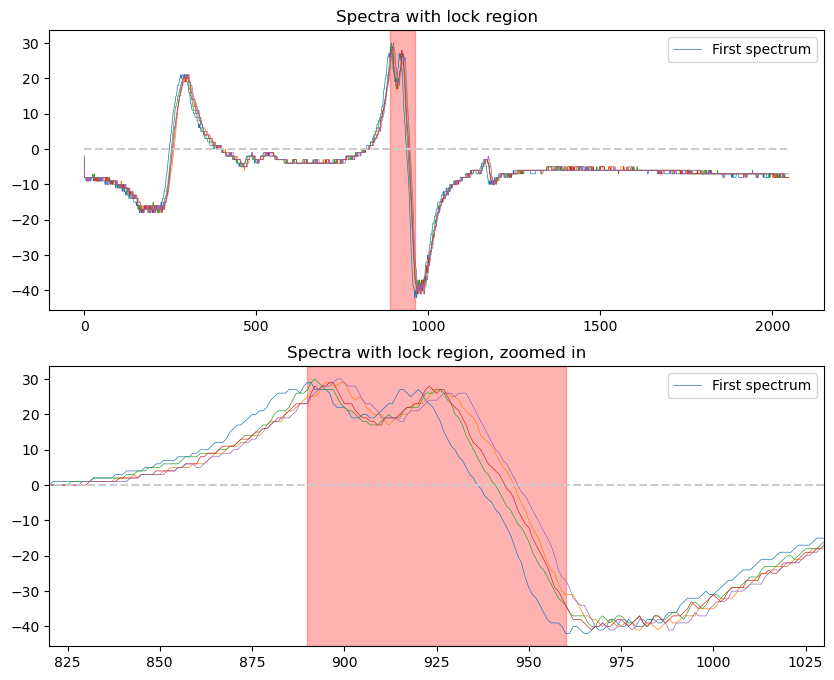

In [130]:
# Visualize the spectra and highlight the lock region

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

for i in range(N_SPECTRA):
    if i == 0:
        axs[0].plot(spectra[i], lw=0.5, label = 'First spectrum')
    else:
        axs[0].plot(spectra[i], lw=0.5)

x0 = target_idxs[0]
x1 = target_idxs[1]
axs[0].hlines(0, 0, spectra.shape[1], color = '0.8', ls = '--')
axs[0].axvspan(x0, x1, color='red', alpha=0.3)
axs[0].set_title('Spectra with lock region')
axs[0].legend()

#Zoom to highlight the jitter
for i in range(N_SPECTRA):
    if i == 0:
        axs[1].plot(spectra[i], lw=0.5, label = 'First spectrum')
    else:
        axs[1].plot(spectra[i], lw=0.5)

x0 = target_idxs[0]
x1 = target_idxs[1]
window_width = x1 - x0
axs[1].hlines(0, 0, spectra.shape[1], color = '0.8', ls = '--')
axs[1].axvspan(x0, x1, color='red', alpha=0.3)
axs[1].set_title('Spectra with lock region, zoomed in')
axs[1].set_xlim(x0-window_width, x1+window_width)
axs[1].legend()


--- spectra_cropped properties ---
spectra_cropped shape: 
 (5, 2038)
spectra_cropped: 
 [[-2. -8. -8. ... -8. -8. -8.]
 [-8. -8. -8. ... -8. -8. -8.]
 [-8. -8. -9. ... -8. -8. -8.]
 [-9. -9. -9. ... -8. -8. -8.]
 [-8. -9. -9. ... -7. -7. -7.]]

--- crop_left properties ---
crop_left: 
 0


Text(0.5, 1.0, 'Spectra with lock region after cropping, zoomed in')

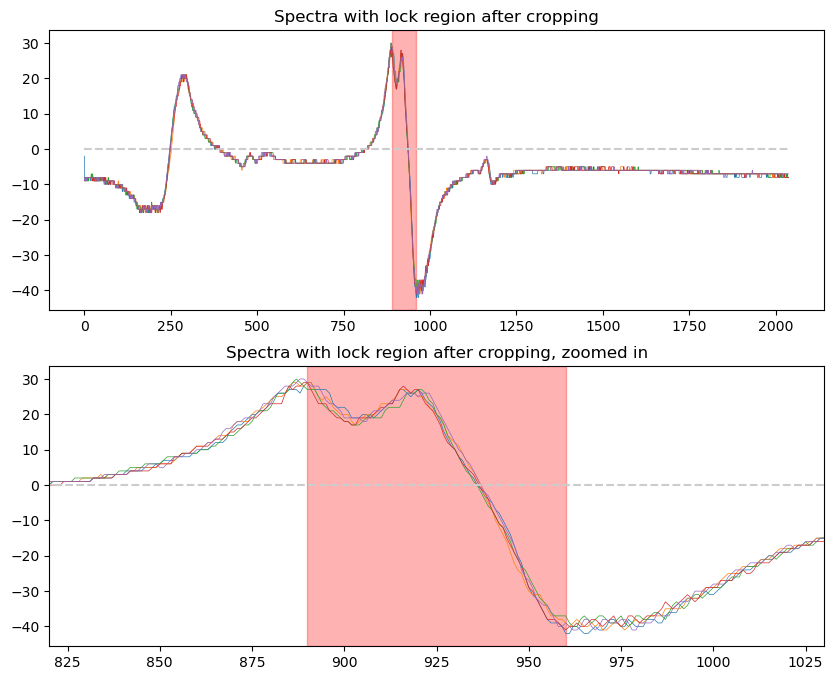

In [131]:
target_idxs = (x0,x1)

spectra_cropped, crop_left = crop_spectra_to_same_view(spectra)
spectra_cropped = np.array(spectra_cropped)

print("--- spectra_cropped properties ---")
print("spectra_cropped shape: \n", spectra_cropped.shape)
print("spectra_cropped: \n", spectra_cropped)

print("\n--- crop_left properties ---")
print("crop_left: \n", crop_left)

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

for i in range(N_SPECTRA):
    axs[0].plot(spectra_cropped[i], lw=0.5)

target_idxs = [idx - crop_left for idx in target_idxs]

axs[0].hlines(0, 0, spectra_cropped.shape[1], color = '0.8', ls = '--')
axs[0].axvspan(target_idxs[0], target_idxs[1], color='red', alpha=0.3)
axs[0].set_title('Spectra with lock region after cropping')

for i in range(N_SPECTRA):
    axs[1].plot(spectra_cropped[i], lw=0.5)

window_width_cropped = target_idxs[1] - target_idxs[0]
axs[1].hlines(0, 0, spectra_cropped.shape[1], color = '0.8', ls = '--')
axs[1].axvspan(target_idxs[0], target_idxs[1], color='red', alpha=0.3)
axs[1].set_xlim(target_idxs[0] - window_width_cropped, target_idxs[1] + window_width_cropped)
axs[1].set_title('Spectra with lock region after cropping, zoomed in')

If we are centered decently these two should be similar:
time_scale 65
window_width_cropped 70


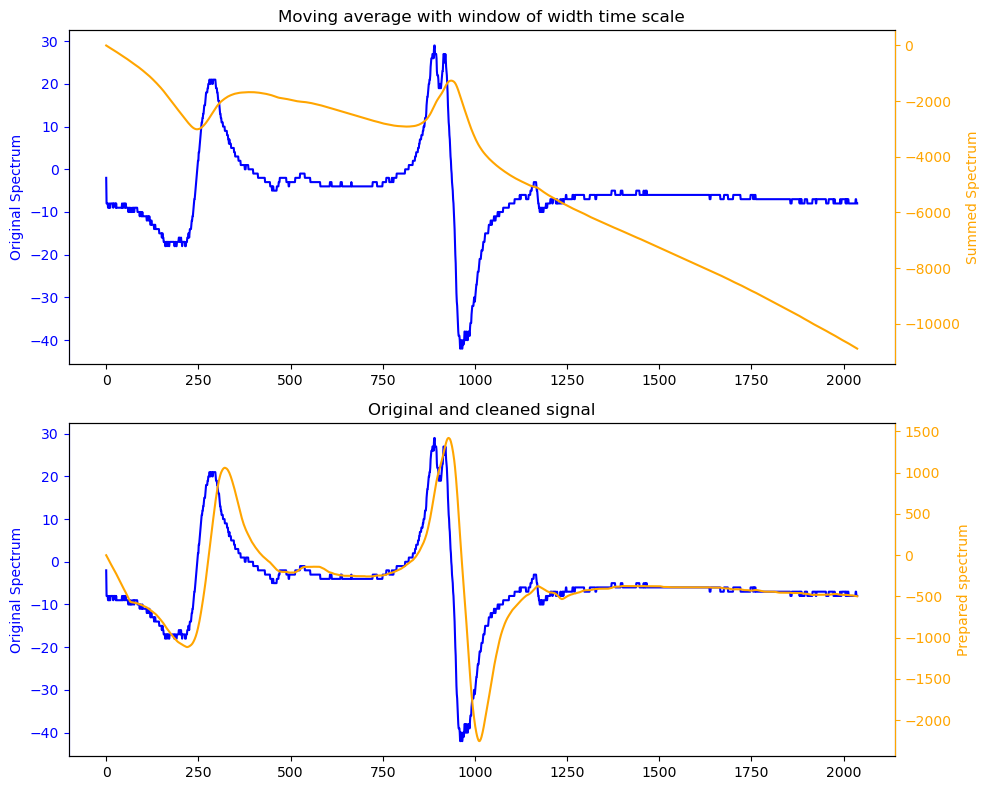

In [132]:
time_scale = int(round(np.mean([get_time_scale(spectrum, target_idxs) for spectrum in spectra]))) #not with 
#the cropped one? They have 
#been translated with respect to te locking window so the values coul be changed
print('If we are centered decently these two should be similar:')
print('time_scale', time_scale)
print('window_width_cropped', window_width_cropped)

prepared_spectrum = get_diff_at_time_scale(sum_up_spectrum(spectra_cropped[0]), time_scale) #to clean the signal 
#they use a moving average and then they re-derive it

#--- original spectrum and its moving average ---

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

ax0 = axs[0] # Primary y-axis
ax1 = ax0.twinx() # Secondary y-axis

# Plot data
color0 = 'blue'
color1 = 'orange'

ax0.plot(spectra_cropped[0], label='Original spectrum', color=color0)
ax1.plot(sum_up_spectrum(spectra_cropped[0]), label='Summed spectrum', color=color1)

# Set y-axis labels with matching colors
ax0.set_ylabel("Original Spectrum", color=color0)
ax1.set_ylabel("Summed Spectrum", color=color1)

# Color tick labels to match lines
ax0.tick_params(axis='y', colors=color0)
ax1.tick_params(axis='y', colors=color1)

# Also color the axis spines (left and right)
ax0.spines['left'].set_color(color0)
ax1.spines['right'].set_color(color1)

# Set title
ax0.set_title("Moving average with window of width time scale")

# --- comparison between the original signal and the cleqned one ---

ax2 = axs[1] # Primary y-axis
ax3 = ax2.twinx() # Secondary y-axis

ax2.plot(spectra_cropped[0], label='Original spectrum', color=color0)
ax3.plot(prepared_spectrum, label='Prepared spectrum', color=color1)

# Set y-axis labels with matching colors
ax2.set_ylabel("Original Spectrum", color=color0)
ax3.set_ylabel("Prepared spectrum", color=color1)

# Color tick labels to match lines
ax2.tick_params(axis='y', colors=color0)
ax3.tick_params(axis='y', colors=color1)

# Also color the axis spines (left and right)
ax2.spines['left'].set_color(color0)
ax3.spines['right'].set_color(color1)

# Set title
ax2.set_title("Original and cleaned signal")

plt.tight_layout()
plt.show()

Due to the structure of the moving average the reconstructed signal will be translated with respect to the original one. Now we want to fix this shifting the target indexes too.

shift 31


[]

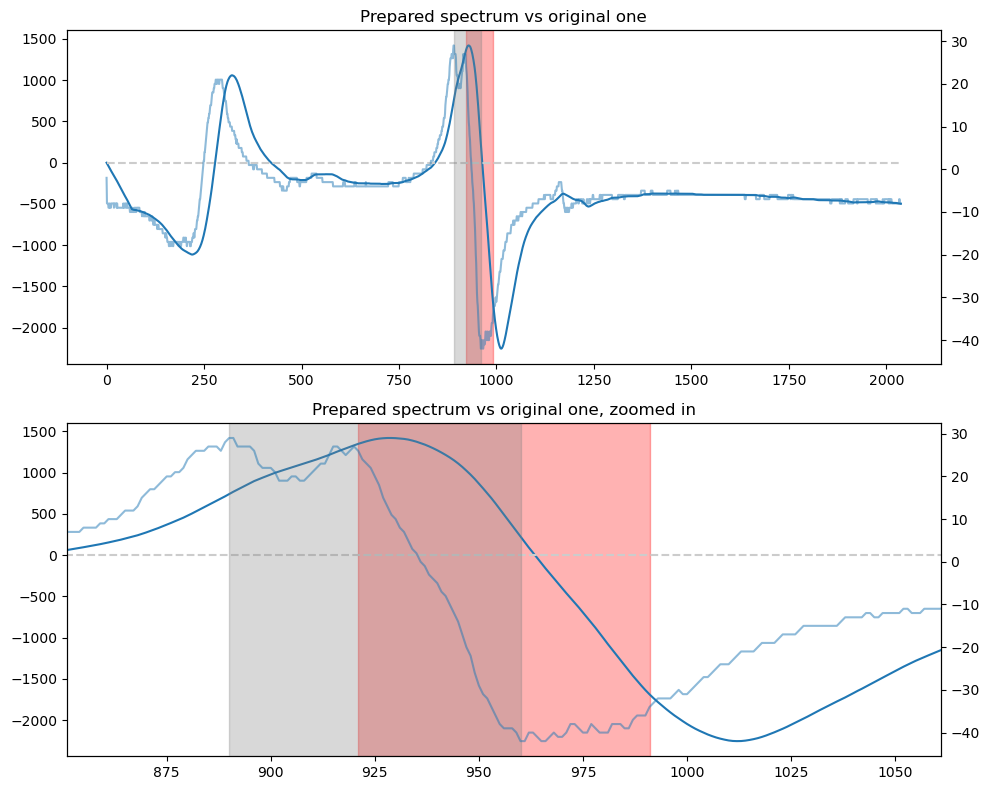

In [133]:

shift_prepared = np.argmax(correlate(prepared_spectrum, spectra_cropped[0]))-len(prepared_spectrum)
print('shift', shift_prepared)

target_idxs_prepared = [idx + shift_prepared for idx in target_idxs]

#--- prepared spectrum plot ---

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

ax0 = axs[0] # Primary y-axis
ax1 = ax0.twinx() # Secondary y-axis

ax0.plot(prepared_spectrum)
ax1.plot(spectra_cropped[0], alpha=0.5)

ax0.hlines(0, 0, len(prepared_spectrum), color = '0.8', ls = '--')
ax1.axvspan(target_idxs[0], target_idxs[1], color='grey', alpha=0.3)
ax0.axvspan(target_idxs_prepared[0], target_idxs_prepared[1], color='red', alpha=0.3)
ax0.set_title('Prepared spectrum vs original one')

ax2 = axs[1] # Primary y-axis
ax3 = ax2.twinx() # Secondary y-axis

ax2.plot(prepared_spectrum)
ax3.plot(spectra_cropped[0], alpha=0.5)

window_width_cropped_prepared = target_idxs_prepared[1] - target_idxs_prepared[0]
ax2.hlines(0, 0, len(prepared_spectrum), color = '0.8', ls = '--')
ax3.axvspan(target_idxs[0], target_idxs[1], color='grey', alpha=0.3)
ax2.axvspan(target_idxs_prepared[0], target_idxs_prepared[1], color='red', alpha=0.3)
ax2.set_xlim(target_idxs_prepared[0] - window_width_cropped_prepared, target_idxs_prepared[1] + window_width_cropped_prepared)
ax2.set_title('Prepared spectrum vs original one, zoomed in')

plt.tight_layout()
plt.plot()

Now the algorithm finds the peaks of the prepared signal. This is using their algorithm but this does not take into account the fact that not all apectra cross the zero between a peak and the next one.

first peak is in  928  with value  1418.0
peaks [(928, 1418.0), (722, -259.0), (322, 1057.0), (220, -1114.0)]
peaks [(928, 1418.0), (928, 1418.0), (722, -259.0), (322, 1057.0), (220, -1114.0)]
y_scale 1418.0


/tmp/ipykernel_53246/2333468014.py:15: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



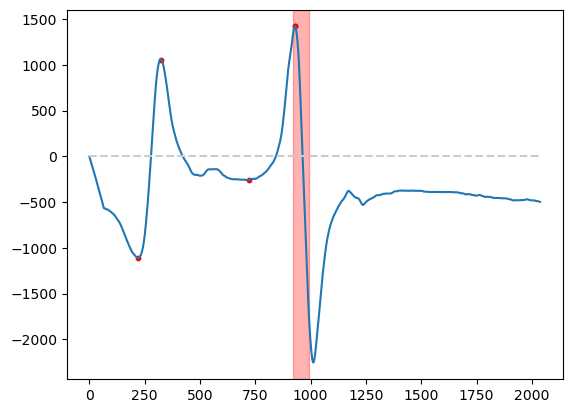

In [134]:
#peaks = get_all_peaks(prepared_spectrum, target_idxs_prepared)
#print('peaks', peaks)
### FOR THE MOMENT WE ADD BY HAND THE TARGET PEAK
#peaks.insert(0, (get_target_peak(prepared_spectrum, target_idxs_prepared), prepared_spectrum[get_target_peak(prepared_spectrum, target_idxs_prepared)]))
#print('peaks', peaks)
##fig = go.Figure()
##fig.add_trace(go.Scatter(x = list(range(len(prepared_spectrum))), y = prepared_spectrum, name='Prepared Spectrum'))
#plt.plot(prepared_spectrum)
#plt.axvspan(target_idxs_prepared[0], target_idxs_prepared[1], color='red', alpha=0.3)
#plt.hlines(0, 0, len(prepared_spectrum), color = '0.8', ls = '--')
#for peak_position,peak_value in peaks:
#    plt.scatter(peak_position, peak_value, color='red',s=10)
#y_scale = peaks[0][1]
#print('y_scale', y_scale)
#fig.show()

So we try to implement a new algorithm defining a shift to have a new "zero rossing" to correctly identify all the peaks.

first peak is in  928  with value  1118.0
peaks [(928, 1418.0), (722, -259.0), (322, 1057.0), (220, -1114.0)]
y_scale 1418.0


/tmp/ipykernel_53246/3096489498.py:20: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



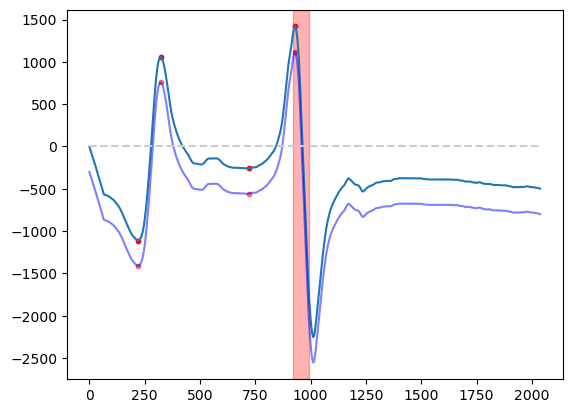

In [135]:
offset = -300 # - (+) to shift the signal down (up)
prepared_spectrum_offset = [value + offset for value in prepared_spectrum]
peaks_offset = get_all_peaks(prepared_spectrum_offset, target_idxs_prepared)
peaks = []
for i in range(len(peaks_offset)):
    peaks.append((peaks_offset[i][0], peaks_offset[i][1] - offset))
print('peaks', peaks)
plt.plot(prepared_spectrum)
plt.plot(prepared_spectrum_offset, alpha=0.5, color = 'b')
plt.axvspan(target_idxs_prepared[0], target_idxs_prepared[1], color='red', alpha=0.3)
plt.hlines(0, 0, len(prepared_spectrum), color = '0.8', ls = '--')
for peak_position,peak_value in peaks:
    plt.scatter(peak_position, peak_value, color='red',s=10)
for peak_position,peak_value in peaks_offset:
    plt.scatter(peak_position, peak_value, color='red',s=10, alpha=0.5)
y_scale = peaks[0][1]
print('y_scale', y_scale)
fig.show()

[(840, 975), (840, 974), (840, 973), (840, 975), (840, 974)]


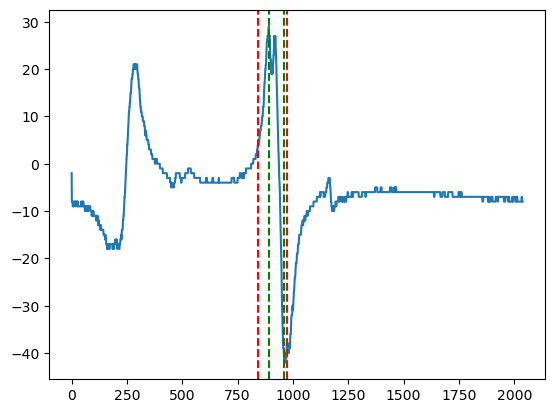

In [136]:
part = spectra_cropped[0][target_idxs[0] : target_idxs[1]]
extrema = tuple(
    sorted([target_idxs[0] + np.argmin(part), target_idxs[0] + np.argmax(part)])
)
#print('std dev of the signal in the desired window:', np.std(spectra_cropped[0][1100:1200]))
lock_regions = [get_lock_region(spectrum, target_idxs, prepared_spectrum) for spectrum in spectra_cropped]
print(lock_regions)
plt.plot(spectra_cropped[0])
plt.axvline(x=lock_regions[0][0], color='r', linestyle='--')
plt.axvline(x=lock_regions[0][1], color='r', linestyle='--')

plt.axvline(x=extrema[0], color='g', linestyle='--')
plt.axvline(x=extrema[1], color='g', linestyle='--')

--- tolerance factor 0.95
original peaks [(928, 1418.0), (722, -259.0), (322, 1057.0), (220, -1114.0)]
peaks filtered [(928, 1347.1), (722, -246.04999999999998), (322, 1004.15), (220, -1058.3)]
target peak idx 928
final wait time 7
description is [(213, -1058), (98, 1004), (388, -246), (199, 1347)]
detected peak at 214 with height -1104.0 for threshold -1058
detected peak at 313 with height 1012.0 for threshold 1004
detected peak at 702 with height -257.0 for threshold -246
detected peak at 921 with height 1347.0 for threshold 1347
lock_position 928
detected peak at 218 with height -1060.0 for threshold -1058
detected peak at 328 with height 1005.0 for threshold 1004
detected peak at 717 with height -249.0 for threshold -246
detected peak at 930 with height 1358.0 for threshold 1347
lock_position 937
detected peak at 214 with height -1068.0 for threshold -1058
detected peak at 322 with height 1009.0 for threshold 1004
detected peak at 711 with height -250.0 for threshold -246
detected 

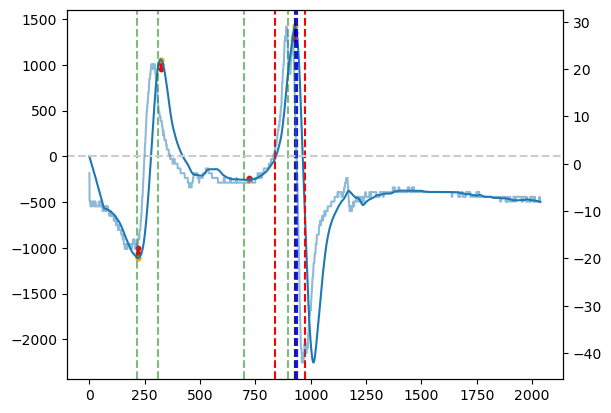

In [137]:
fig, ax0 = plt.subplots()

ax1 = ax0.twinx() # Secondary y-axis

ax0.plot(prepared_spectrum)
for tolerance_factor in [0.95,0.9,0.85,0.8,0.75,0.7]:
        #logger.debug(f"Try out tolerance {tolerance_factor}")
        peaks_filtered = [
            (peak_position, peak_height * tolerance_factor)
            for peak_position, peak_height in peaks
        ] #reduces by 1-tolerance factor the height of the peaks ot see if they are significant

        # it is important to do the filtering that happens here after the previous
        # line as the previous line shrinks the values
        peaks_filtered = [
            (peak_position, peak_height)
            for peak_position, peak_height in peaks_filtered
            if abs(peak_height) > abs(y_scale * (1 - tolerance_factor))
        ] # keeps only significant peaks
        print('--- tolerance factor', tolerance_factor)
        print('original peaks', peaks)
        print('peaks filtered', peaks_filtered)
    
        # now we have to find how much reducing the threshold influences our wait
        #time for the target peak (we will actually detect it earlier than it appears)
        target_peak_described_height = peaks_filtered[0][1]
        target_peak_idx = get_target_peak(prepared_spectrum, target_idxs_prepared)
        print('target peak idx', target_peak_idx)
        ax0.axvline(x=target_peak_idx, color='k', linestyle='--', alpha=0.5)

        for peak_position, peak_height in peaks:
            ax0.scatter(peak_position, peak_height, color='orange', s=10)

        for peak_position, peak_height in peaks_filtered:
            ax0.scatter(peak_position, peak_height, color='red', s=10)

        #-------
        #the problem lies in the evaluation of final wait time. This should be the time to
        #wait from the detection of the last peak to the target peak
        current_idx = target_peak_idx
        while True:
            current_idx -= 1
            if np.abs(prepared_spectrum[current_idx]) < np.abs(
                target_peak_described_height
            ): #this is triggered in the first index to the left of the target
            #peak that is below the described height
                break
        final_wait_time = target_peak_idx - current_idx
        #logger.debug(f"final wait time is {final_wait_time} samples")
        print('final wait time', final_wait_time)
        #-------

        description = []

        last_peak_position = 0
        for peak_position, peak_height in list(reversed(peaks_filtered)):
            # TODO: this .9 factor is very arbitrary.
            description.append(
                (int(0.97 * (peak_position - last_peak_position)), int(peak_height))
            )
            last_peak_position = peak_position
        print('description is', description)

        counter = 0
        for x in description:
            counter += x[0]
            ax0.axvline(counter, color='g', linestyle='--', alpha=0.3)

        # test whether description works fine for every recorded spectrum
        does_work = True
        for spectrum, lock_region in zip(spectra, lock_regions):
            try:
                lock_position = get_lock_position_from_autolock_instructions(
                    spectrum, description, time_scale, spectra_cropped[0], final_wait_time
                )
                print('lock_position', lock_position)
                ax0.axvline(x=lock_position, color='b', linestyle='--', alpha=0.3)
                if not lock_region[0] <= lock_position <= lock_region[1]:
                    print('LockPositionNotFound')

            except:
                does_work = False

        if does_work:
            break
ax0.axvline(x=lock_regions[0][0], color='r', linestyle='--')
ax0.axvline(x=lock_regions[0][1], color='r', linestyle='--')
ax1.plot(spectra_cropped[0], alpha=0.5)
ax0.axhline(0, 0, len(prepared_spectrum), color = '0.8', ls = '--')
#plt.axvline(x=extrema[0], color='g', linestyle='--')
#plt.axvline(x=extrema[1], color='g', linestyle='--')

plt.show()

detected peak at 214 with height -1104.0 for threshold -1002
detected peak at 313 with height 1012.0 for threshold 951
detected peak at 702 with height -257.0 for threshold -233
detected peak at 918 with height 1291.0 for threshold 1276
lock_position 929
detected peak at 214 with height -1077.0 for threshold -1002
detected peak at 315 with height 960.0 for threshold 951
detected peak at 704 with height -249.0 for threshold -233
detected peak at 917 with height 1286.0 for threshold 1276
lock_position 928
detected peak at 214 with height -1085.0 for threshold -1002
detected peak at 313 with height 975.0 for threshold 951
detected peak at 702 with height -246.0 for threshold -233
detected peak at 921 with height 1286.0 for threshold 1276
lock_position 932
detected peak at 214 with height -1090.0 for threshold -1002
detected peak at 314 with height 958.0 for threshold 951
detected peak at 703 with height -244.0 for threshold -233
detected peak at 919 with height 1276.0 for threshold 1276
l

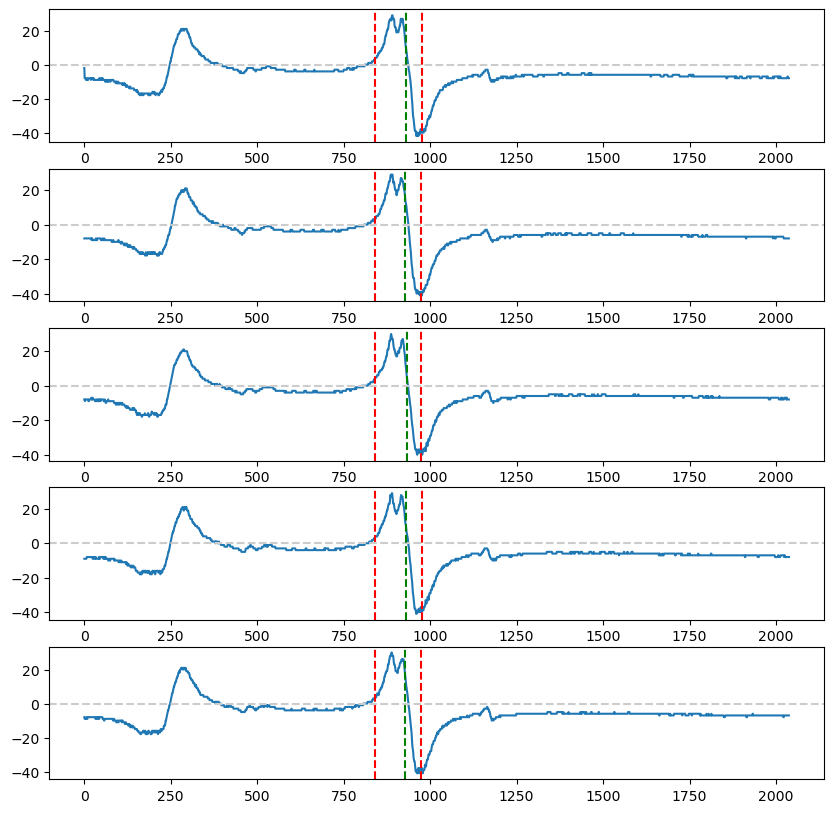

In [138]:
fig,ax = plt.subplots(ncols=1, nrows=N_SPECTRA, figsize=(10, 10))
for i in range(N_SPECTRA):
    ax[i].plot(spectra_cropped[i])
    ax[i].axvline(x=lock_regions[i][0], color='r', linestyle='--')
    ax[i].axvline(x=lock_regions[i][1], color='r', linestyle='--')
    ax[i].axhline(0, 0, len(spectra_cropped[i]), color = '0.8', ls = '--')
    lock_position = get_lock_position_from_autolock_instructions(
                    spectra_cropped[i], description, time_scale, spectra_cropped[0], final_wait_time
                )
    print('lock_position', lock_position)
    ax[i].axvline(x=lock_position, color='g', linestyle='--')

Calculation of autolock description took 0.07282376289367676
--- resulting instructions ---
peaks description: [(215, -1103), (99, 1029), (385, -257), (200, 1376)]
final_wait_time: 8
time_scale: 68
peaks [(215, -1103), (314, 1029), (699, -257), (899, 1376)]
peaks relative heights [(215, 0.8015988372093024), (314, 0.7478197674418605), (699, 0.1867732558139535), (899, 1.0)]


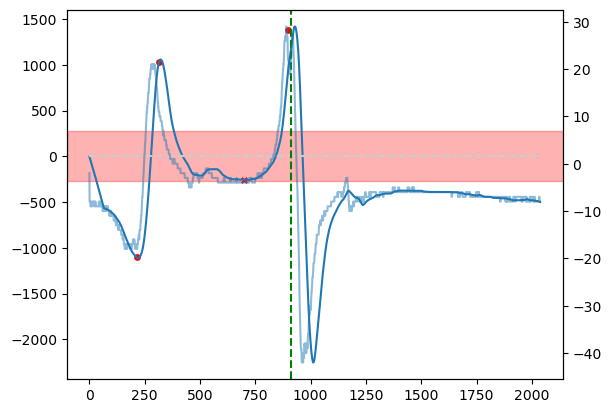

In [149]:
t1 = time()
res = calculate_autolock_instructions(spectra, (x0, x1), -300)
t2 = time()
dt = t2 - t1
clear_output()
print(f"Calculation of autolock description took {dt}")
print('--- resulting instructions ---')
print('peaks description:', res[0])
print('final_wait_time:', res[1])
print('time_scale:', res[2])

peaks = []
idx = 0
for i in range(len(res[0])):
    idx += res[0][i][0]
    peaks.append((idx, res[0][i][1]))
    
fig, ax0 = plt.subplots()
ax1 = ax0.twinx() # Secondary y-axis

ax0.plot(prepared_spectrum)
ax1.plot(spectra_cropped[0], alpha=0.5)
ax0.hlines(0, 0, len(prepared_spectrum), color = '0.8', ls = '--')
ax0.axvline(idx+final_wait_time, color='g', linestyle='--')

# --- we want to get rid of the undesired peaks ---
peak_threshold_factor = 0.2 #all the peaks with height less than peak_threshold_factor*maximum_height will be ignored
maximum_height = max( np.abs(peaks[i][1]) for i in range(len(peaks)))
peaks_relative_heights = [(peak_position, abs(peak_height/maximum_height)) for peak_position, peak_height in peaks]
print('peaks', peaks)
print('peaks relative heights', peaks_relative_heights)
ax0.axhspan(-peak_threshold_factor*maximum_height, peak_threshold_factor*maximum_height, color='red', alpha=0.3)

discarded_description = []
accepted_description = []
discarded_peaks = []
accepted_peaks = []

for i in range(len(peaks_relative_heights)):
    if peaks_relative_heights[i][1] < peak_threshold_factor:
        discarded_description.append( (res[0][i][0], res[0][i][1]) )
        discarded_peaks.append( peaks[i] )
    else:
        accepted_description.append( (res[0][i][0], res[0][i][1]) )
        accepted_peaks.append( peaks[i] )

for peak_position, peak_height in accepted_peaks:
    ax0.scatter(peak_position, peak_height, color='red', s=15)
for peak_position, peak_height in discarded_peaks:
    ax0.scatter(peak_position, peak_height, color='red', s=15, marker='x')
